In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import Tube, InterpXY, BorderSimple
from gaslayer import GasEOS, GasFluxCalculator, GridStrecher, GasLayer
from math import *
import numpy as np

In [3]:
from tqdm import tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

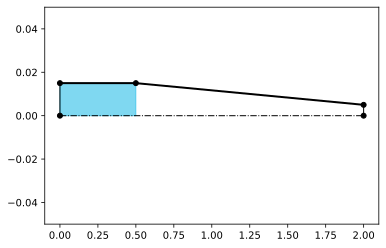

GasLayer(n_cells=300); 
        {'p_max':5000000.0, 'tau_min': 4.800463324675617e-06, 
        'u_max': 0.0, 'cs_max': 347.18870949384285, 'dx_min': 0.0016666666666666496, 
        'x_1': 0.0, 'x_2': 0.5,
        'V_1':  0.0, 'V_2':  0.0  }

In [48]:
def get_layer0():   
    l_0 = 0.5
    n_cells=300
    d = 30e-3
    p_0 = 5e6
    l = 2

    gas_layer_dict_sample = {
        'type': 'gas',
        'name': 'air',
        'gamma': 1.4,
        'kappa': 0,
        'R': 287,
        'T_0': 300, # K
        'W_0': 0.0003,  # м^3 объем газа
        'p_0': p_0, # начальное давление газа
        'u_0': 0,     #начальная скорость
        'x_2': l_0
    }

    tube_dict = {
        'tube_points': [[0, d], [l_0, d], [l, 0.01]]
    }

    calc_settings_sample = {
        'cell_dx': 0.0025,
        'n_cells': n_cells,
        'n_cells_min': 13,
        'n_cells_max': 300,
        'GasFluxCalculator_kwargs': { 'flux_type':2 },
        'GridStrecher_kwargs': {}
    }   
    tube=Tube.get_standart(tube_dict)
    gl = GasLayer.get_standart(tube, 0, gas_layer_dict_sample, calc_settings_sample)   
    return gl

gl = get_layer0()
fig, ax = plt.subplots()
gl.tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

gl

In [49]:
def calc_sol_all(m=0.1, ku=0.5):
    gl = get_layer0()
    ku = 0.5
    lrs = [gl]
    for i in range(100000):
        if gl.xs_borders[-1] >= gl.tube.get_xs()[-1]:
            break
        tau = gl.get_tau_min()*ku
        v_left = gl.Vs_borders[-1] + gl.S[-1] * gl.ps[-1] / m * tau
        gl = gl.step_simple(tau, 0, v_left)
        lrs.append(gl)
    return lrs
lrs = calc_sol_all(m=0.1, ku=0.5)

In [50]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=1, value=0))
def plotMe(ind):
    param_name = 'us'
    lr = lrs[ind]
    fig, ax = plt.subplots()
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax.plot(xs, ys, color=color, lw=lw)
    plt.grid(True)
    plt.ylabel(param_name)
#     plt.ylim(-1,6e6)
    plt.title(f't={lr.time*1000} ms; i={ind}')
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=3512), Output()), _dom_classes=('widget-intera…

In [51]:
lrs[-1].Vs_borders[-1]

168.19771454034807

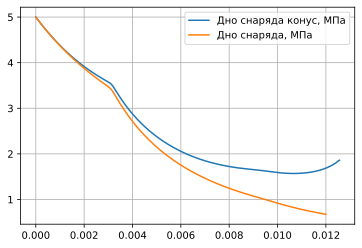

In [47]:
from functional import seq

ts2 = seq(lrs).map(lambda lr: lr.time).to_list()
dno_snar2 = seq(lrs).map(lambda lr: lr.ps[-1]/1e6).to_list()
# dno = seq(lrs).map(lambda lr: lr.ps[0]/1e6 ]).to_list()
plt.plot(ts, dno_snar, label='Дно снаряда конус, МПа')
plt.plot(ts2, dno_snar2, label='Дно снаряда, МПа')
# plt.plot(ts, dno, label='Дно, МПа')
plt.legend()
plt.grid(True)
plt.show()
